In [65]:
#importing the required libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa.display
import soundfile
import os
# matplotlib complains about the behaviour of librosa.display, so we'll ignore those warnings:
import warnings; warnings.filterwarnings('ignore')

In [66]:
def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0)
    return mfc_coefficients

In [67]:
def preprocess_waveform(waveform):
    # If the waveform has 2 channels (stereo), convert it to mono
    if len(waveform.shape) > 1:
        waveform = librosa.to_mono(waveform)
    return waveform

In [68]:
def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # make sure the file is mono channel audio
        waveform = preprocess_waveform(waveform)
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)

        feature_matrix=np.array([])

        # Check the shape of chromagram
        if chromagram.ndim > 1 and chromagram.shape[1] > 1:
            #print(f"Returning zero vector for chromagram size: {file} (shape: {chromagram.shape})")
            chromagram = np.zeros((12,))  # Return a zero vector of size (12,)

        # Check the shape of mel spectrogram
        if melspectrogram.ndim > 1 and melspectrogram.shape[1] > 1:
            #print(f"Returning zero vector for mel spectrogram size: {file} (shape: {melspectrogram.shape})")
            melspectrogram = np.zeros((128,))  # Return a zero vector of size (128,)

        # Check the shape of MFCC coefficients
        if mfc_coefficients.ndim > 1 and mfc_coefficients.shape[1] > 1:
            #print(f"Returning zero vector for MFCC size: {file} (shape: {mfc_coefficients.shape})")
            mfc_coefficients = np.zeros((40,))  # Return a zero vector of size (40,)

        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))

        return feature_matrix

In [69]:
emotions_dict ={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

In [70]:
import os, glob

def load_data():
    X,y=[],[]
    count = 0
    for file in glob.glob("/Users/hamoui/Downloads/Audio Data/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions_dict[file_name.split("-")[2]]
        features = get_features(file)
        X.append(features)
        y.append(emotion)
        count += 1
        # '\r' + end='' results in printing over same line
        print('\r' + f' Processed {count}/{1440} audio samples',end=' ')
    # Return arrays to plug into sklearn's cross-validation algorithms
    return np.array(X), np.array(y)

In [71]:
features, emotions = load_data()

 Processed 1439/1440 audio samples 

In [72]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')
features_df = pd.DataFrame(features) # make it pretty for display


#making dataframe for emotions as well
emotions_df = pd.DataFrame(emotions) # make it pretty for display

features_df


Audio samples represented: 1439
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.552245,0.504338,0.512779,0.550540,0.572176,0.615567,0.603708,0.573230,0.593454,0.603834,...,-3.543537,-0.912676,-1.747537,-2.299447,-0.025205,2.449470,2.116510,3.361054,2.086241,0.376519
1,0.550732,0.508484,0.466809,0.438485,0.428218,0.445352,0.444528,0.444478,0.500419,0.551672,...,2.333152,3.619089,0.793563,0.743431,0.660723,-0.254914,-0.967536,0.378563,-0.338074,-0.463241
2,0.672768,0.601451,0.548317,0.477806,0.453192,0.516665,0.570100,0.599750,0.647746,0.692148,...,0.283253,0.218117,-1.928165,-2.486516,-0.530147,0.354905,0.463640,0.581006,-2.091462,-1.899596
3,0.602309,0.605448,0.558788,0.529441,0.546190,0.568049,0.566027,0.523464,0.526789,0.552809,...,2.176564,3.904047,0.980935,1.160923,-0.694902,-0.969963,-0.234802,0.941701,0.695973,0.430566
4,0.556555,0.503434,0.473118,0.479222,0.495470,0.522490,0.532196,0.540681,0.545616,0.512521,...,-1.306030,0.050261,-0.992539,-0.213367,-0.351018,-1.462262,-2.454565,-1.044801,-0.298479,0.118208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,0.664177,0.633587,0.590743,0.601933,0.623832,0.643299,0.671203,0.668196,0.683204,0.658825,...,5.234397,5.000974,4.120271,3.053777,2.119890,2.965642,2.442994,2.014850,3.167833,4.008449
1435,0.697806,0.658317,0.614802,0.639169,0.717383,0.743908,0.781170,0.749796,0.722322,0.715267,...,-1.211285,0.060299,-1.140080,0.446977,0.614657,0.430341,0.332445,-0.197219,0.797524,2.606972
1436,0.628023,0.596604,0.643935,0.655228,0.659819,0.725635,0.808151,0.814369,0.771093,0.722508,...,-1.125915,0.213711,-1.729091,0.776150,0.564957,2.507703,0.997837,0.844502,-0.108339,2.037053
1437,0.630163,0.652205,0.637307,0.684746,0.764458,0.795282,0.819000,0.802949,0.774911,0.734925,...,-2.221260,-0.709731,-1.652230,-1.931097,-1.620286,1.130693,0.274002,2.252403,2.537369,3.869970


In [89]:
features_df.to_csv('featuresRavdess.csv')
emotions_df.to_csv('emotionsRavdess.csv')

In [90]:
import os, glob

def load_data():
    X,y=[],[]
    count = 0
    for file in glob.glob("/Users/hamoui/Downloads/Actor_25/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions_dict[file_name.split("-")[2]]
        features = get_features(file)
        X.append(features)
        y.append(emotion)
        count += 1
        # '\r' + end='' results in printing over same line
        print('\r' + f' Processed {count}/{1440} audio samples',end=' ')
    # Return arrays to plug into sklearn's cross-validation algorithms
    return np.array(X), np.array(y)

In [91]:
my_features, my_emotions = load_data()

 Processed 16/1440 audio samples 

In [92]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')
my_features_df = pd.DataFrame(my_features) # make it pretty for display


#making dataframe for emotions as well
my_emotions_df = pd.DataFrame(my_emotions) # make it pretty for display

my_features_df


Audio samples represented: 1439
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.617916,0.696612,0.794701,0.755629,0.662991,0.578879,0.613557,0.585381,0.542465,0.571288,...,1.000654,0.807646,1.512550,-2.588176,2.150454,1.623150,2.166183,-1.267928,-0.451758,-3.644000
1,0.999219,1.000000,0.993107,0.993467,0.987711,0.982193,0.977960,0.978807,0.985013,0.988497,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.644077,0.686421,0.632604,0.599113,0.560519,0.559823,0.595128,0.583142,0.602467,0.661341,...,-1.951501,-3.981042,-3.292469,-4.768622,-0.500898,0.815163,0.514791,0.167665,1.168006,-1.371461
3,0.999219,1.000000,0.993107,0.993467,0.987711,0.982193,0.977960,0.978808,0.985013,0.988497,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.662319,0.618134,0.674340,0.758930,0.647482,0.498800,0.500288,0.554216,0.596683,0.612554,...,-0.052116,-0.011730,-1.156936,-2.133076,2.539018,1.108461,1.852884,-0.382154,-0.246951,-1.708799
5,0.999219,1.000000,0.993107,0.993467,0.987711,0.982193,0.977960,0.978808,0.985013,0.988497,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.718671,0.742762,0.706201,0.630200,0.591473,0.646801,0.744091,0.729545,0.698102,0.733377,...,-2.089340,0.871405,-0.937814,-2.560682,1.625933,0.355061,1.508124,-0.708404,-1.462838,-2.019936
7,0.582274,0.637062,0.686622,0.739903,0.641213,0.496154,0.468342,0.452765,0.469877,0.533751,...,-0.132103,-1.474185,1.997424,-4.393844,-0.628210,0.644001,-0.797757,-1.997087,-2.512849,-4.101810
8,0.490278,0.514055,0.600981,0.697008,0.610848,0.489967,0.467152,0.485856,0.622945,0.689259,...,-4.859961,-3.536712,-0.345686,-3.497211,-0.513559,1.514338,0.452864,0.311506,-1.389621,-1.321672
9,0.601884,0.601691,0.701094,0.750359,0.609702,0.459607,0.492529,0.552341,0.543066,0.515500,...,-0.908250,-0.458091,-0.167920,-2.370970,0.156682,1.055502,1.088111,-1.105553,-2.101116,-2.258471


In [93]:
my_features_df.to_csv('myfeaturesRavdess.csv')
my_emotions_df.to_csv('myemotionsRavdess.csv')

In [94]:
features=pd.read_csv('featuresRavdess.csv',index_col=0)
emotions=pd.read_csv('emotionsRavdess.csv',index_col=0)

In [95]:
my_features=pd.read_csv('myfeaturesRavdess.csv',index_col=0)
my_emotions=pd.read_csv('myemotionsRavdess.csv',index_col=0)

In [96]:
features.head()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.552245,0.504338,0.512779,0.550540,0.572176,0.615567,0.603708,0.573230,0.593454,0.603834,...,-3.543537,-0.912676,-1.747537,-2.299447,-0.025205,2.449470,2.116510,3.361054,2.086241,0.376519
1,0.550732,0.508484,0.466809,0.438485,0.428218,0.445352,0.444528,0.444478,0.500419,0.551672,...,2.333152,3.619089,0.793563,0.743431,0.660723,-0.254914,-0.967536,0.378563,-0.338074,-0.463241
2,0.672768,0.601451,0.548318,0.477806,0.453192,0.516665,0.570100,0.599750,0.647746,0.692148,...,0.283253,0.218117,-1.928165,-2.486515,-0.530147,0.354905,0.463640,0.581006,-2.091462,-1.899596
3,0.602309,0.605448,0.558788,0.529441,0.546190,0.568049,0.566027,0.523464,0.526789,0.552809,...,2.176565,3.904047,0.980935,1.160923,-0.694902,-0.969963,-0.234802,0.941701,0.695973,0.430566
4,0.556555,0.503434,0.473118,0.479222,0.495470,0.522490,0.532196,0.540681,0.545616,0.512521,...,-1.306030,0.050261,-0.992538,-0.213367,-0.351018,-1.462262,-2.454565,-1.044801,-0.298479,0.118208


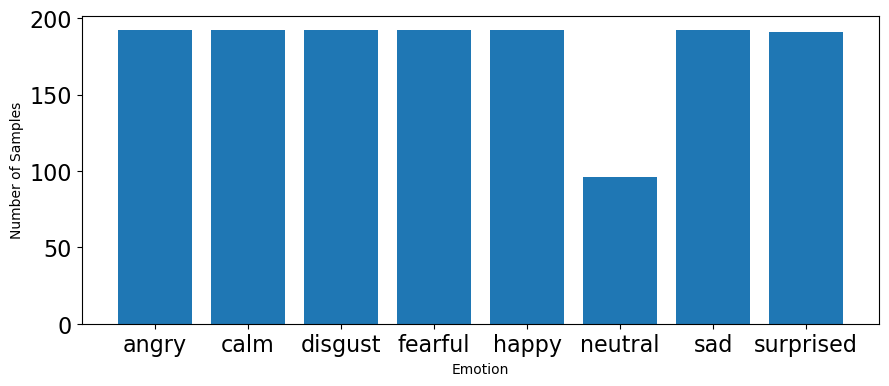

In [97]:
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(emotions, return_counts=True)
plt.bar(x=range(8), height=count)
plt.xticks(ticks=range(8), labels = [emotion for emotion in emotion_list],fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

In [98]:
def print_features(df):
    # Check chromagram feature values
    features_df_chromagram = df.loc[:,:11]
    chroma_min = features_df_chromagram.min().min()
    chroma_max = features_df_chromagram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    chroma_mean = features_df_chromagram.stack().mean()
    chroma_stdev = features_df_chromagram.stack().std()
    print(f'12 Chromagram features:       \
    min = {chroma_min:.3f}, \
    max = {chroma_max:.3f}, \
    mean = {chroma_mean:.3f}, \
    deviation = {chroma_stdev:.3f}')

    # Check mel spectrogram feature values
    features_df_melspectrogram = df.loc[:,12:139]
    mel_min = features_df_melspectrogram.min().min()
    mel_max = features_df_melspectrogram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mel_mean = features_df_melspectrogram.stack().mean()
    mel_stdev = features_df_melspectrogram.stack().std()
    print(f'\n128 Mel Spectrogram features: \
    min = {mel_min:.3f}, \
    max = {mel_max:.3f}, \
    mean = {mel_mean:.3f}, \
    deviation = {mel_stdev:.3f}')

    # Check MFCC feature values
    features_df_mfcc = df.loc[:,140:179]
    mfcc_min = features_df_mfcc.min().min()
    mfcc_max = features_df_mfcc.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mfcc_mean = features_df_mfcc.stack().mean()
    mfcc_stdev = features_df_mfcc.stack().std()
    print(f'\n40 MFCC features:             \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    deviation = {mfcc_stdev:.3f}')

print_features(features_df)

12 Chromagram features:           min = 0.310,     max = 1.000,     mean = 0.667,     deviation = 0.087

128 Mel Spectrogram features:     min = 0.000,     max = 149.208,     mean = 0.187,     deviation = 1.597

40 MFCC features:                 min = -1131.371,    max = 115.126,    mean = -14.674,    deviation = 98.873


In [99]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = features
features_scaled = scaler.fit_transform(features_scaled)

scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
features_minmax = features
features_minmax = scaler.fit_transform(features_minmax)

In [100]:
print('\033[1m'+'Standard Scaling:\n'+'\033[0m')
features_scaled_df = pd.DataFrame(features_scaled)
print_features(features_scaled_df)

print('\n\n\033[1m'+'MinMax Scaling:\n'+'\033[0m')
features_minmax_df = pd.DataFrame(features_minmax)
print_features(features_minmax_df)

Standard Scaling:

12 Chromagram features:           min = -3.896,     max = 4.368,     mean = -0.000,     deviation = 1.000

128 Mel Spectrogram features:     min = -0.474,     max = 36.531,     mean = 0.000,     deviation = 1.000

40 MFCC features:                 min = -4.803,    max = 6.238,    mean = 0.000,    deviation = 1.000


MinMax Scaling:

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.472,     deviation = 0.145

128 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.015,     deviation = 0.061

40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.412,    deviation = 0.169


In [101]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

my_scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
my_features_scaled = my_features
my_features_scaled = my_scaler.fit_transform(my_features_scaled)

my_scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
my_features_minmax = my_features
my_features_minmax = my_scaler.fit_transform(my_features_minmax)

In [102]:
print('\033[1m'+'Standard Scaling:\n'+'\033[0m')
my_features_scaled_df = pd.DataFrame(my_features_scaled)
print_features(my_features_scaled_df)

print('\n\n\033[1m'+'MinMax Scaling:\n'+'\033[0m')
my_features_minmax_df = pd.DataFrame(my_features_minmax)
print_features(my_features_minmax_df)

Standard Scaling:

12 Chromagram features:           min = -1.427,     max = 1.453,     mean = -0.000,     deviation = 1.003

128 Mel Spectrogram features:     min = -1.305,     max = 3.863,     mean = 0.000,     deviation = 1.000

40 MFCC features:                 min = -2.903,    max = 2.528,    mean = -0.000,    deviation = 1.001


MinMax Scaling:

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.465,     deviation = 0.381

128 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.204,     deviation = 0.294

40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.559,    deviation = 0.322


In [103]:
from sklearn.model_selection import train_test_split


############# Unscaled test/train set #############
X_train, X_test, y_train, y_test =train_test_split(
    features,
    emotions,
    test_size=0.2,
    random_state=42
)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=42
)

############# MinMax Scaled test/train set ###############
# The labels/classes (y_train, y_test) never change, keep old values
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=42
)

Add 2nd column to this table and use own data to show test results, then try RAW features and minmax. Then talk about which AI has a better results based on which data.

In [113]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classification_models = [
    KNeighborsClassifier(7),
    SVC(kernel='linear', C=0.025),
    SVC(kernel='rbf', C=10, gamma='auto', random_state=42),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)
    my_score = model.score(my_features_scaled, my_emotions)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%'),(f'{100*my_score:.2f}%')))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score','Audio_25 Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

,Classifier,Accuracy Score,Audio_25 Score
2,SVC RBF kernel,68.40%,50.00%
0,KNeighborsClassifier,52.78%,37.50%
1,SVC,50.00%,50.00%
3,DecisionTreeClassifier,40.97%,18.75%
4,RandomForestClassifier,40.97%,12.50%
6,GaussianNB,32.29%,25.00%
5,AdaBoostClassifier,31.94%,18.75%
7,QuadraticDiscriminantAnalysis,23.96%,31.25%


In [116]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classification_models = [
    KNeighborsClassifier(7),
    SVC(kernel='linear', C=0.025),
    SVC(kernel='rbf', C=10, gamma='auto', random_state=42),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores2 = []
for model in classification_models:
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    my_score = model.score(my_features, my_emotions)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores2.append((model_name,(f'{100*score:.2f}%'),(f'{100*my_score:.2f}%')))
    
# Make it pretty
scores_df2 = pd.DataFrame(scores2,columns=['Classifier','Accuracy Score','Audio_25 Score'])
scores_df2.sort_values(by='Accuracy Score',axis=0,ascending=False)

,Classifier,Accuracy Score,Audio_25 Score
2,SVC RBF kernel,52.78%,6.25%
1,SVC,50.69%,6.25%
0,KNeighborsClassifier,46.18%,12.50%
3,DecisionTreeClassifier,40.97%,12.50%
4,RandomForestClassifier,38.19%,25.00%
5,AdaBoostClassifier,31.94%,18.75%
6,GaussianNB,30.90%,18.75%
7,QuadraticDiscriminantAnalysis,22.22%,12.50%


In [117]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classification_models = [
    KNeighborsClassifier(7),
    SVC(kernel='linear', C=0.025),
    SVC(kernel='rbf', C=10, gamma='auto', random_state=42),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores3 = []
for model in classification_models:
    model.fit(X_train_minmax, y_train)
    score = model.score(X_test_minmax, y_test)
    my_score = model.score(my_features_minmax, my_emotions)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores3.append((model_name,(f'{100*score:.2f}%'),(f'{100*my_score:.2f}%')))
    
# Make it pretty
scores_df3 = pd.DataFrame(scores3,columns=['Classifier','Accuracy Score','Audio_25 Score'])
scores_df3.sort_values(by='Accuracy Score',axis=0,ascending=False)

,Classifier,Accuracy Score,Audio_25 Score
2,SVC RBF kernel,68.40%,31.25%
0,KNeighborsClassifier,52.78%,25.00%
1,SVC,50.00%,37.50%
4,RandomForestClassifier,43.06%,12.50%
3,DecisionTreeClassifier,40.97%,25.00%
6,GaussianNB,32.29%,6.25%
5,AdaBoostClassifier,31.94%,18.75%
7,QuadraticDiscriminantAnalysis,23.96%,18.75%


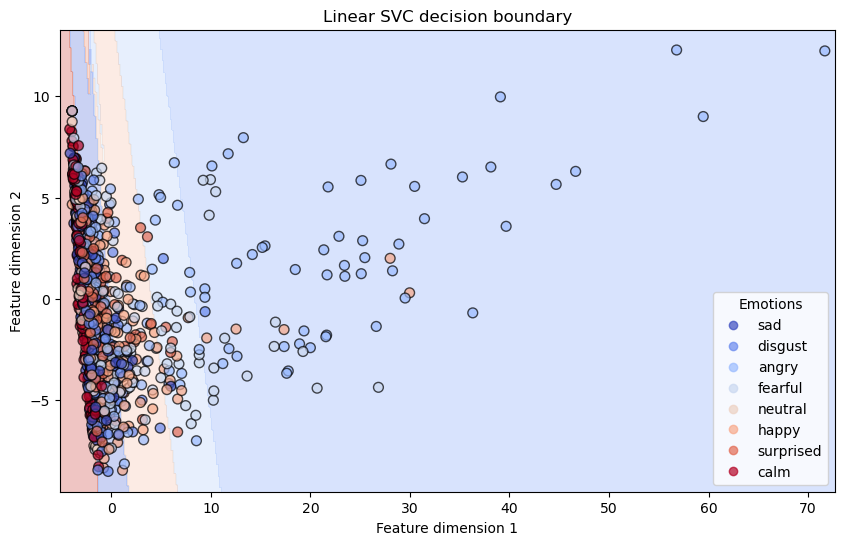

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import pandas as pd

X_train_scaled = np.array(X_train_scaled, dtype=float)
X_test_scaled = np.array(X_test_scaled, dtype=float)

X_train_scaled = np.nan_to_num(X_train_scaled)
X_test_scaled = np.nan_to_num(X_test_scaled)

y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()

y_train = [str(label) for label in y_train]
y_test = [str(label) for label in y_test]

pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

y_train_encoded, label_names = pd.factorize(y_train)

svc_linear = SVC(kernel='linear', C=0.25, random_state=42, gamma='auto')
svc_linear.fit(X_train_pca, y_train_encoded)

x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

Z = svc_linear.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
                      c=y_train_encoded, cmap=plt.cm.coolwarm,
                      edgecolor='k', s=50, alpha=0.7)

plt.xlabel("Feature dimension 1")
plt.ylabel("Feature dimension 2")
plt.title("Linear SVC decision boundary")

label_names = list(label_names)

handles, _ = scatter.legend_elements()
plt.legend(handles=handles, labels=label_names, loc="best", title="Emotions")

plt.show()

In [106]:
model.predict(my_features_scaled)

array(['angry', 'disgust', 'calm', 'disgust', 'sad', 'disgust', 'neutral',
       'angry', 'angry', 'fearful', 'fearful', 'neutral', 'angry', 'sad',
       'disgust', 'disgust'], dtype=object)

In [107]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.svm import SVC

model = SVC(
    C=10,  #higher the value tighter the margin
    gamma='auto',
    kernel='rbf',
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f'Test Set Accuracy score = {100*accuracy_score(y_test, y_pred):.3f}%')
print(f'Test Set Precision score = {100*precision_score(y_test, y_pred, average="macro"):.3f}%')
print(f'Test Set Recall score = {100*recall_score(y_test, y_pred, average="macro"):.3f}%')
print(f'Test Set F1-score score = {100*f1_score(y_test, y_pred, average="macro"):.3f}%')

Test Set Accuracy score = 52.778%
Test Set Precision score = 53.436%
Test Set Recall score = 51.942%
Test Set F1-score score = 51.893%


In [108]:
from sklearn.svm import SVC

model = SVC(
    C=10,  #higher the value tighter the margin
    gamma='auto',
    kernel='rbf',
    random_state=42
)

model.fit(X_train, y_train)

print(f'SVC Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'SVC Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

SVC Model's accuracy on training set is 99.74%
SVC Model's accuracy on test set is 52.78%


In [109]:
from sklearn.neighbors import KNeighborsClassifier

####### Default kNN  ########
model = KNeighborsClassifier(
)

model.fit(X_train, y_train)

print(f'Default kNN Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default kNN Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')

##### (hastily) tuned kNN ######
model = KNeighborsClassifier(
    n_neighbors = 5,
    weights = 'distance',
    algorithm = 'brute',
    n_jobs=4
)

model.fit(X_train, y_train)

print(f'kNN Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'kNN Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Default kNN Model's accuracy on training set is 66.90%
Default kNN Model's accuracy on test set is 46.88%

kNN Model's accuracy on training set is 99.74%
kNN Model's accuracy on test set is 51.04%


In [110]:
from sklearn.ensemble import RandomForestClassifier

####### Default Random Forest ########
model = RandomForestClassifier(
    random_state=69
)

model.fit(X_train, y_train)

print(f'Default Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')


########## Tuned Random Forest #######
model = RandomForestClassifier(
    n_estimators = 500,
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = True, # more on this below
    random_state=42
)

model.fit(X_train, y_train)

print(f'Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Default Random Forest Model's accuracy on training set is 100.00%
Default Random Forest Model's accuracy on test set is 57.29%

Random Forest Model's accuracy on training set is 100.00%
Random Forest Model's accuracy on test set is 61.81%
